### どこで誤差が生じているかEDAをして確認する

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)
import plotly.express as px

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import mean_squared_error


import os
import gc
# print(os.listdir("././input"))
# print(os.listdir("././submit"))

SEED=1234
n_splits=10

### check_LeaderBoard

In [5]:
df=pd.read_table('./input/leaderboard.txt',header=None)
df[1]=range(1,59)

[]

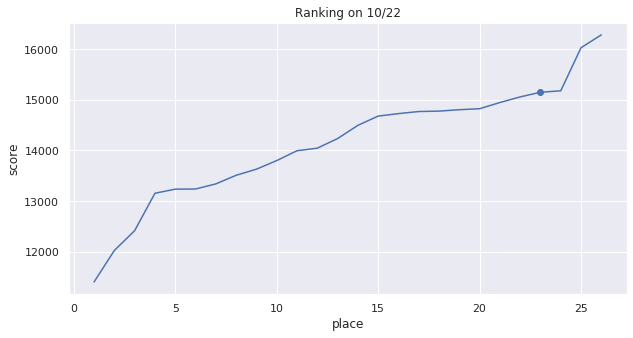

In [6]:
plt.figure(figsize=(10,5))
palette = sns.color_palette("mako_r", 1)
sns.lineplot(x=1,y=0,markers=True,palette=palette, dashes=True,data=df.loc[:25,:])
plt.scatter(23,15148)
plt.title('Ranking on 10/22')
plt.ylabel('score')
plt.xlabel('place')
plt.savefig('./input/now_place.png')
plt.plot()

In [7]:
train=pd.read_csv('./input/pred_train.csv')
test=pd.read_csv('./input/pred_test.csv')
raw_test=pd.read_csv('./input/test.csv')
raw_train=pd.read_csv('./input/train.csv')

In [8]:
train['abs_diff']=np.abs(train['賃料']-train['oof'])
train['diff']=train['賃料']-train['oof']

## 面積
面積が大きくなればなるほど誤差が大きくなる。   
面積×何かの特徴量を作れるといいかも

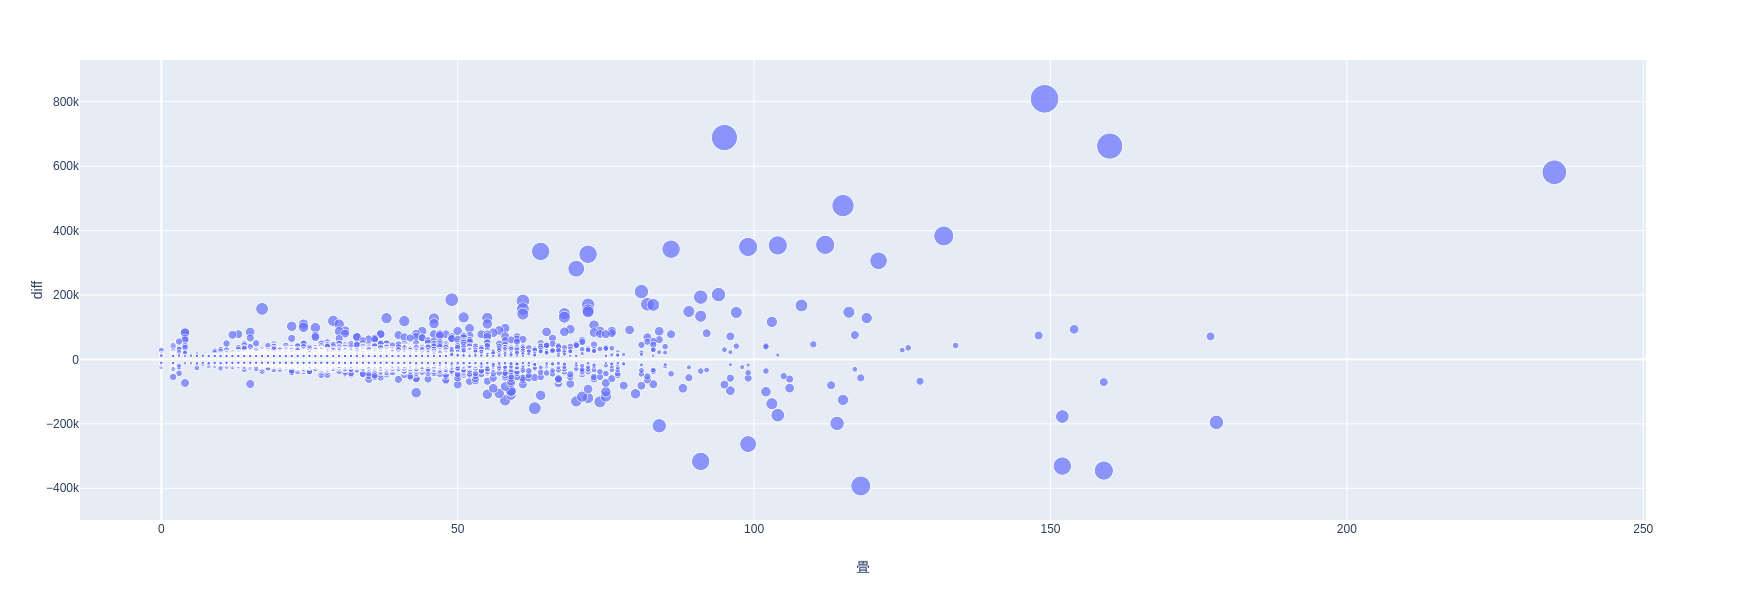

In [9]:
mini_train=train.sort_values('abs_diff',ascending=False).head(5000)
fig = px.scatter(mini_train, x="畳", y="diff",text='id',size='abs_diff')
fig.show()

### Location

In [10]:
test.head(1)

Unnamed: 0     id  契約期間 建物構造  所在階 方角  築年数  賃料   間取り    面積 駐車場  -  専用トイレ  \
0           0  31471     0  鉄骨造  8.0  南  588 NaN  2LDK  50.0   無  0      1   

   洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  浴室乾燥機  共同トイレ  \
0      1     1     1        1       1    1     0     0      0      0      0   

   シャワー    駅名  新築   畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  インターネット対応  CSアンテナ  \
0     1  等々力駅   0  34       0             0     0       0          1       0   

   高速インターネット  CATV   loc_lat     loc_lon    center_dis  city city2  借家  \
0          0     0  35.61772  139.652763  10561.359582  世田谷区    深沢   0   

   契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  【小学校】_num  【飲食店】_dis  【飲食店】_num  \
0         0          0          0        219          1          0          0   

   【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  \
0          74           1              0              0          0          0   

   【総合病院】_dis  【総合病院】_num  【学校】_dis  【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  \
0           0           0       252         1              0              0   

   【銀行】_dis  【銀行】_num  【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  \
0         0         0             0             0           0           0   

   【コインパーキング】_dis  【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  \
0               0               0            0            0       313   

   【病院】_num  【公園】_dis  【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  \
0         1         0         0              0              0         215   

   【スーパー】_num  【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  \
0           1         0         0     0    0       1    0             0   

   トランクルーム  プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  \
0        0       0       0     0   0     1         0    0        0      0   

   シューズボックス  下水  出窓  ペアガラス  二重サッシ  洗濯機置場なし  地下室  3面採光  敷地内ごみ置き場  汲み取り  ガスその他  \
0         1   1   0      0      0        0    0     0         0     0      0   

   公営水道  水道その他  クッションフロア  2面採光  エアコン付  床下収納  エレベーター  タイル張り  専用庭  ロフト付き  井戸  \
0     1      0         0     0      1     0       1      0    0      0   0   

   二世帯住宅  24時間換気システム  排水その他  バルコニー  室内洗濯機置場  戸建て  総階数  地下階数  納戸  部屋数  L  D  K  \
0      0           0      0      1        0    0  8.0     0   0    2  1  1  1   

   LDK  DK  コンロ2口  コンロ3口  コンロ1口  カウンターキッチン  コンロ4口以上  コンロ設置可（コンロ4口以上）  IHコンロ  \
0    1   1      0      1      0          0        0                0      0   

   電気コンロ  給湯  冷蔵庫あり  コンロ設置可（コンロ3口）  コンロ設置可（コンロ1口）  独立キッチン  ガスコンロ  \
0      0   1      0              0              0       0      1   

   コンロ設置可（コンロ2口）  システムキッチン  コンロ設置可（口数不明）  L字キッチン 駐輪場 バイク置き場    sta_lat  \
0              0         1             0       1  空有      -  35.608349   

      sta_lon  station_dis  station_dis_min  station_num  nearest_station  \
0  139.648072  1123.253453      1123.253453            3                1   

   2012年平均単価  2017年平均単価  上昇率  2012平均単価_mean  2012平均単価_max  2012平均単価_min  \
0   604940.0   649639.0  7.4       615371.0      631013.0      604940.0   

   2017平均単価_mean  2017平均単価_max  2017平均単価_min   上昇率_mean  上昇率_max  上昇率_min  \
0  698755.333333      749667.0      649639.0  13.466667     18.8      7.4   

          target  
0  109723.682454

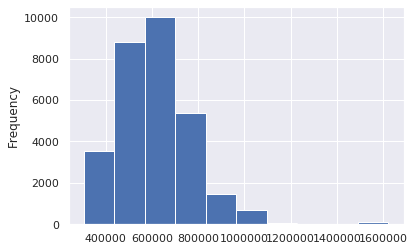

In [11]:
train['2017年平均単価'].plot.hist()

In [12]:
loc_tr=train[['id','y_train','oof','loc_lat','loc_lon']]
loc_te=test[['target','loc_lat','loc_lon']]
loc_tr['diff']=loc_tr['oof']-loc_tr['y_train']

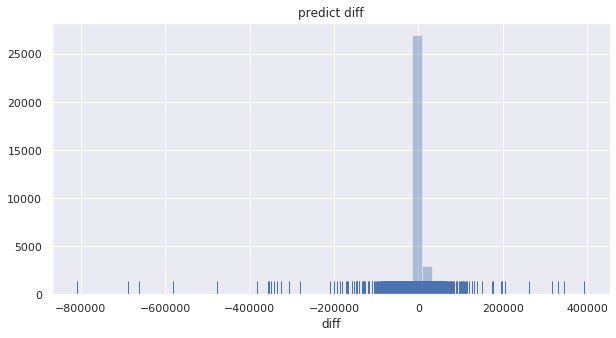

In [13]:
#低く見積もれがち
plt.figure(figsize=(10,5))
plt.title('predict diff')
sns.distplot(loc_tr['diff'],rug=True, norm_hist=False,kde=False)
plt.show()

In [14]:
loc_tr2=loc_tr.copy()
loc_tr2.loc[loc_tr2['diff']>200000,'oof']=loc_tr2['y_train']
print('20万以上高く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']>200000,'oof']))
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))

loc_tr2=loc_tr.copy()
print('20万以上安く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']<-200000,'oof']))
loc_tr2.loc[loc_tr2['diff']<-200000,'oof']=loc_tr2['y_train']
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))
print()
loc_tr2=loc_tr.copy()
loc_tr2.loc[loc_tr2['diff']>100000,'oof']=loc_tr2['y_train']
print('10万以上高く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']>100000,'oof']))
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))

loc_tr2=loc_tr.copy()
print('10万以上安く見積もられている建物の数:',len(loc_tr2.loc[loc_tr2['diff']<-100000,'oof']))
loc_tr2.loc[loc_tr2['diff']<-100000,'oof']=loc_tr2['y_train']
print('これらを正しく予測できたときのRMSE:',np.sqrt(mean_squared_error(loc_tr2['oof'], loc_tr2['y_train'])))

20万以上高く見積もられている建物の数: 6
これらを正しく予測できたときのRMSE: 15436.166208354653
20万以上安く見積もられている建物の数: 16
これらを正しく予測できたときのRMSE: 12409.546144002277

10万以上高く見積もられている建物の数: 28
これらを正しく予測できたときのRMSE: 15031.464823890046
10万以上安く見積もられている建物の数: 48
これらを正しく予測できたときのRMSE: 11549.387494781471


In [15]:
loc_tr['abs']=np.abs(loc_tr['diff'])

In [16]:
loc_tr2=loc_tr.sort_values('abs',ascending=False)[:300]

In [17]:
import chart_studio
chart_studio.tools.set_credentials_file(username='zerebom', api_key='pk.eyJ1IjoiemVyZWJvbSIsImEiOiJjanpjY2JkZWUwMHMwM2RwNmQyanM2cHg4In0.VvajXw6UybbJhgp_-fHeY')
chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

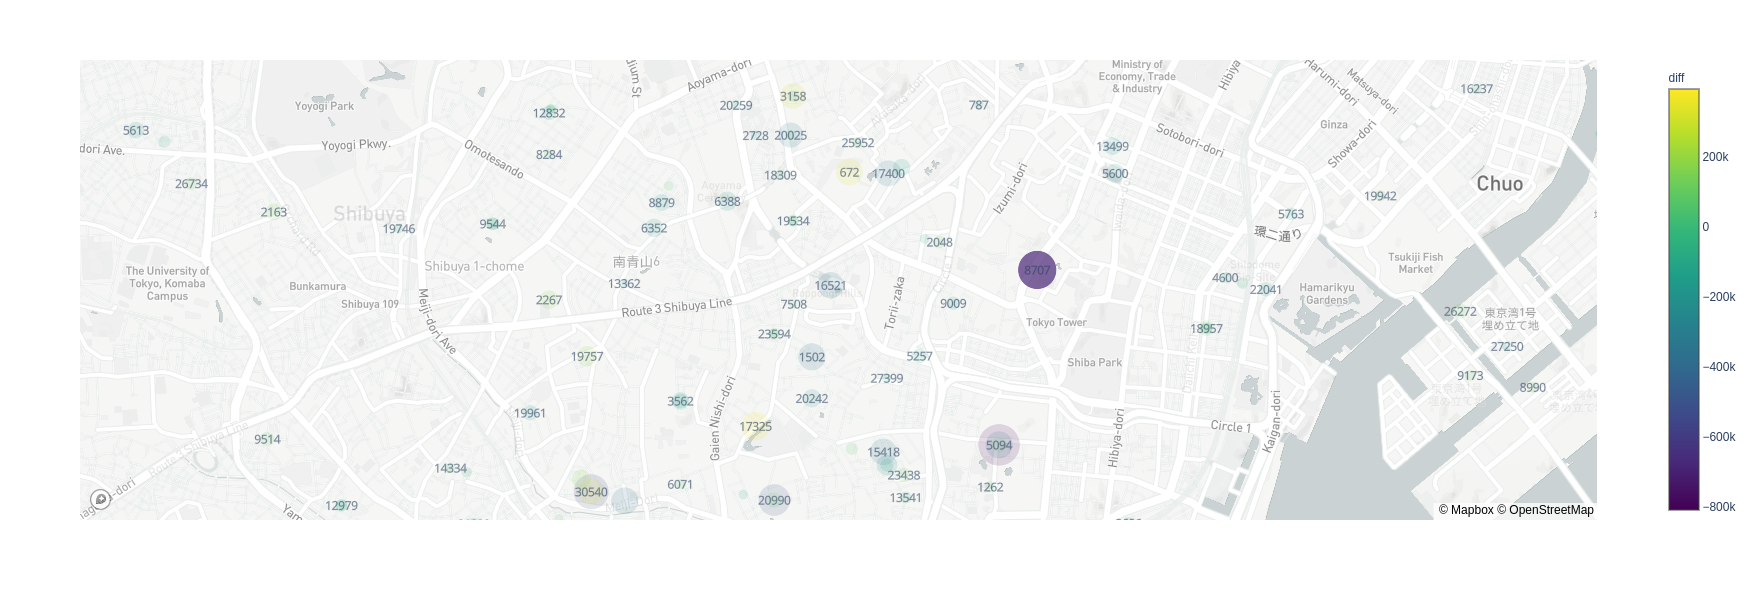

In [18]:
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1IjoiemVyZWJvbSIsImEiOiJjanpjY2JkZWUwMHMwM2RwNmQyanM2cHg4In0.VvajXw6UybbJhgp_-fHeYw')
fig = px.scatter_mapbox(loc_tr2, lat="loc_lat", lon="loc_lon",  color="diff", size="abs",text='id',
                  color_continuous_scale=px.colors.sequential.Viridis, size_max=30, zoom=10)
fig.show()

In [45]:
raw_train.loc[raw_train['id'].isin(big_diff_idx)]

id       賃料              所在地  \
671      672   900000       東京都港区赤坂９丁目   
1501    1502  1200000      東京都港区元麻布３丁目   
1771    1772  1450000    東京都大田区田園調布３丁目   
3157    3158   550000       東京都港区赤坂８丁目   
5093    5094  2500000    東京都港区三田２丁目4-3   
6563    6564   700000       東京都千代田区一番町   
6972    6973   530000       東京都千代田区三番町   
8706    8707  1390000  東京都港区虎ノ門５丁目11-1   
11367  11368  1100000      東京都新宿区新宿６丁目   
11958  11959  1120000      東京都渋谷区広尾１丁目   
15417  15418  1300000  東京都港区南麻布１丁目16-2   
16520  16521   880000      東京都港区六本木６丁目   
17324  17325  1100000      東京都港区南麻布５丁目   
17399  17400   850000  東京都港区赤坂６丁目19-36   
17658  17659   650000      東京都港区南麻布１丁目   
20024  20025  1100000  東京都港区赤坂８丁目11-38   
20643  20644  1800000    東京都港区三田２丁目4-3   
20989  20990  1300000      東京都港区南麻布４丁目   
25551  25552  1120000   東京都渋谷区広尾１丁目8-7   
30539  30540  1660000      東京都渋谷区広尾１丁目   

                                                    アクセス         間取り      築年数  \
671    千代田線\t乃木坂駅\t徒歩6分\t\t千代田線\t赤坂(東京都)駅\t徒歩7分\t\t都営...        5LDK   14年7ヶ月   
1501   南北線\t麻布十番駅\t徒歩9分\t\t都営大江戸線\t六本木駅\t徒歩9分\t\t東京メト...        3LDK   18年6ヶ月   
1771            東急東横線\t田園調布駅\t徒歩5分\t\t東急目黒線\t田園調布駅\t徒歩5分  4LDK+S(納戸)    9年1ヶ月   
3157   半蔵門線\t青山一丁目駅\t徒歩2分\t\t銀座線\t青山一丁目駅\t徒歩2分\t\t東京メ...        3LDK   17年3ヶ月   
5093   南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...  2LDK+S(納戸)    1年8ヶ月   
6563   半蔵門線\t半蔵門駅\t徒歩3分\t\t有楽町線\t麹町駅\t徒歩6分\t\t中央・総武緩行...        2LDK   18年6ヶ月   
6972   総武線・中央線（各停）\t市ケ谷駅\t徒歩6分\t\t半蔵門線\t半蔵門駅\t徒歩8分\t\...        3LDK   16年5ヶ月   
8706   日比谷線\t神谷町駅\t徒歩1分\t\t南北線\t六本木一丁目駅\t徒歩10分\t\t都営三...        2LDK  14年10ヶ月   
11367  都営大江戸線\t東新宿駅\t徒歩2分\t\t都営新宿線\t新宿三丁目駅\t徒歩10分\t\t...        2LDK   25年1ヶ月   
11958  山手線\t恵比寿駅\t徒歩6分\t\t日比谷線\t広尾駅\t徒歩13分\t\t東急東横線\t...        4LDK   22年7ヶ月   
15417  南北線\t麻布十番駅\t徒歩7分\t\t南北線\t白金高輪駅\t徒歩16分\t\t都営大江戸...        2LDK    5年1ヶ月   
16520               日比谷線\t六本木駅\t徒歩5分\t\t南北線\t麻布十番駅\t徒歩9分        2LDK   16年4ヶ月   
17324                                    日比谷線\t広尾駅\t徒歩5分        4LDK    7年0ヶ月   
17399  日比谷線\t六本木駅\t徒歩6分\t\t千代田線\t乃木坂駅\t徒歩8分\t\t南北線\t六...  1LDK+S(納戸)   12年6ヶ月   
17658  都営大江戸線\t麻布十番駅\t徒歩11分\t\t都営三田線\t白金高輪駅\t徒歩12分\t\...        2LDK   41年8ヶ月   
20024  千代田線\t乃木坂駅\t徒歩2分\t\t日比谷線\t六本木駅\t徒歩8分\t\t銀座線\t青...        3LDK    9年0ヶ月   
20643  南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...  2LDK+S(納戸)    1年8ヶ月   
20989  日比谷線\t広尾駅\t徒歩8分\t\t南北線\t麻布十番駅\t徒歩18分\t\t山手線恵比寿...        3LDK   14年9ヶ月   
25551  山手線\t恵比寿駅\t徒歩9分\t\t日比谷線\t広尾駅\t徒歩9分\t\t東急東横線\t代...  1LDK+S(納戸)  13年11ヶ月   
30539                山手線\t恵比寿駅\t徒歩6分\t\t日比谷線\t恵比寿駅\t徒歩6分  4LDK+S(納戸)   22年7ヶ月   

       方角        面積             所在階  \
671     東  231.52m2      ／3階建（地下1階）   
1501   南東  163.62m2          3階／3階建   
1771   南西  232.01m2             2階建   
3157   南東  133.13m2   9階／20階建（地下1階）   
5093    西  217.29m2    9階／9階建（地下2階）   
6563   北東  102.82m2   3階／14階建（地下2階）   
6972    南  144.66m2    3階／9階建（地下1階）   
8706    東  138.99m2         7階／24階建   
11367  南東  192.43m2   9階／10階建（地下1階）   
11958   南   221.3m2        11階／13階建   
15417   北     125m2          7階／7階建   
16520  北西   94.09m2  17階／43階建（地下2階）   
17324  北東  171.43m2    3階／4階建（地下1階）   
17399   東  105.66m2    1階／6階建（地下2階）   
17658   東   117.5m2    1階／3階建（地下1階）   
20024  南西  176.87m2  25階／25階建（地下1階）   
20643   南  151.81m2    5階／9階建（地下2階）   
20989  北東  167.99m2    1階／8階建（地下1階）   
25551   南  144.35m2   9階／10階建（地下1階）   
30539   南   341.3m2  12階／13階建（地下2階）   

                                                  バス・トイレ  \
671    専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...   
1501   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
1771                専用バス／\t専用トイレ／\tシャワー／\t温水洗浄便座／\t洗面台独立   
3157   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
5093   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
6563      専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立   
6972    バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立   
8706   専用バス／\t専用トイレ／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／...   
11367       バス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／\t洗面台独立／\t脱衣所   
11958

In [43]:
big_diff_idx=train.sort_values('diff',ascending=False).head(20)['id'].values
train

id  契約期間          建物構造   所在階   方角  築年数        賃料   間取り     面積 駐車場  \
0          1    24  RC（鉄筋コンクリート）   1.0   南東  117   75000.0    1K  20.01   -   
1          2    24           鉄骨造   5.0  NaN  538   76000.0    1R  16.50   無   
2          3    24  RC（鉄筋コンクリート）  12.0    南  102  110000.0    1K  22.05  近隣   
3          4    24  RC（鉄筋コンクリート）   3.0    南  352  150000.0  2LDK  60.48   無   
4          5    24            木造   1.0    南  379   74000.0   2DK  39.66  近隣   
...      ...   ...           ...   ...  ...  ...       ...   ...    ...  ..   
31458  31466    24           鉄骨造   1.0    南  360   80000.0   2DK  37.90   無   
31459  31467    24  RC（鉄筋コンクリート）   4.0    西  475   54500.0    1R  12.04   無   
31460  31468    24           鉄骨造   3.0    南  550  125000.0   3DK  60.00   -   
31461  31469    24            木造   1.0    南  132   98000.0   1DK  29.59   無   
31462  31470    24           鉄骨造   2.0   南東  722   81000.0    1K  25.00   無   

       -  専用トイレ  洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  \
0      0      1      0     0     1        1       1    0     0     0      0   
1      0      1      0     0     0        0       1    0     0     0      0   
2      0      1      1     0     1        1       1    1     0     0      0   
3      0      1      1     0     1        1       1    0     0     0      0   
4      0      1      0     1     1        1       0    0     0     0      0   
...   ..    ...    ...   ...   ...      ...     ...  ...   ...   ...    ...   
31458  0      1      1     1     1        1       0    0     0     0      0   
31459  0      1      0     0     1        0       0    0     0     0      0   
31460  0      0      0     1     0        1       1    0     0     0      0   
31461  0      1      1     0     1        1       0    0     0     0      0   
31462  0      1      0     0     1        1       0    0     0     0      0   

       浴室乾燥機  共同トイレ  シャワー     駅名  新築   畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  \
0          1      0     1   西巣鴨駅   0  13       0             0     0       1   
1          0      0     1   勝どき駅   0  11       0             0     0       0   
2          1      0     1    笹塚駅   0  15       1             0     0       1   
3          0      0     1   高円寺駅   0  41       1             0     0       0   
4          0      0     1  京成金町駅   0  27       0             0     0       0   
...      ...    ...   ...    ...  ..  ..     ...           ...   ...     ...   
31458      0      0     1    蓮根駅   0  26       0             0     0       0   
31459      0      0     1  三軒茶屋駅   0   8       0             0     0       0   
31460      0      0     1   南砂町駅   0  41       1             0     0       0   
31461      0      0     1    中野駅   0  20       1             0     0       0   
31462      0      0     1    千川駅   0  17       0             0     0       0   

       インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon  \
0              1       1          0     1  35.748456  139.728800   
1              1       0          0     0  35.662885  139.778627   
2              1       1          0     0  35.675153  139.666255   
3              1       0          0     0  35.700170  139.648465   
4              0       0          0     0  35.766431  139.872321   
...          ...     ...        ...   ...        ...         ...   
31458          1       0          0     0  35.782103  139.677100   
31459          0       0          0     0  35.648356  139.668082   
31460          0       0          0     0  35.673436  139.830096   
31461          1       0          0     1  35.703700  139.668807   
31462          0       0          1     0  35.741599  139.691776   

         center_dis  city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  \
0       8179.773244    北区   滝野川   0         0       1246          1   
1       3368.632618   中央区    月島   0         0          0          0   
2       7132.274400   渋谷区    笹塚   0         0          0          0   
3       9145.291052   杉並区  高円寺南   1         0     

誤差が大きい300個を確認  
何箇所か同じ場所で誤差が大きい場所がある

外れ値のマンションを実際に確認。 

### 虎ノ門 
東京都港区虎ノ門５丁目11-1の物件はかなり予測が外れてしまっている。
http://www.moriliving.com/ja/estate/rop/hollandhills
が、Testデータには存在しない。

In [32]:
display(raw_train.loc[raw_train['所在地'].str.contains('虎ノ門')].sort_values('賃料',ascending=False).head(5))
# display(train.loc[train['所在地'].str.contains('虎ノ門')].sort_values('賃料',ascending=False).head(5))

id       賃料              所在地  \
8706    8707  1390000  東京都港区虎ノ門５丁目11-1   
5599    5600   950000  東京都港区虎ノ門１丁目23-1   
13498  13499   950000      東京都港区虎ノ門１丁目   
24578  24579   650000      東京都港区虎ノ門４丁目   
7786    7787   340000      東京都港区虎ノ門３丁目   

                                                    アクセス   間取り      築年数  方角  \
8706   日比谷線\t神谷町駅\t徒歩1分\t\t南北線\t六本木一丁目駅\t徒歩10分\t\t都営三...  2LDK  14年10ヶ月   東   
5599   銀座線\t虎ノ門駅\t徒歩5分\t\t日比谷線\t神谷町駅\t徒歩9分\t\t都営三田線\t...  2LDK    5年3ヶ月   西   
13498  銀座線\t虎ノ門駅\t徒歩5分\t\t都営三田線\t御成門駅\t徒歩10分\t\t山手線\t...  2LDK    5年3ヶ月  北西   
24578  日比谷線\t神谷町駅\t徒歩6分\t\t南北線\t六本木一丁目駅\t徒歩9分\t\t銀座線\...  2LDK  12年11ヶ月  北西   
7786   日比谷線\t神谷町駅\t徒歩4分\t\t銀座線\t虎ノ門駅\t徒歩9分\t\t都営三田線御成...  2LDK   11年4ヶ月  南西   

             面積             所在階  \
8706   138.99m2         7階／24階建   
5599     88.7m2        43階／52階建   
13498    88.7m2  43階／52階建（地下5階）   
24578  113.44m2        37階／41階建   
7786    71.17m2         8階／30階建   

                                                  バス・トイレ  \
8706   専用バス／\t専用トイレ／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／...   
5599   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
13498   バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立   
24578  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   
7786   専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   

                                           キッチン  \
8706   ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン   
5599            ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯   
13498           ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯   
24578  ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン   
7786                    ガスコンロ／\tシステムキッチン\t／\t給湯   

                                             放送・通信  \
8706            インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ   
5599          インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ   
13498                       光ファイバー／\tCATV／\tCSアンテナ   
24578  インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ   
7786                                 光ファイバー／\tCATV   

                                                    室内設備  \
8706   エアコン付\tトランクルーム\t／\tウォークインクローゼット\tバルコニー／\t24時間換...   
5599   エアコン付／\t床暖房\tトランクルーム\t／\tウォークインクローゼット\tシューズボック...   
13498  冷房／\tエアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコ...   
24578  エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...   
7786   エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...   

                                            駐車場  \
8706   駐車場\t空有\t54,000円(税込)\t駐輪場\t空有\tバイク置き場\t無   
5599   駐車場\t空有\t60,000円(税込)\t駐輪場\t空有\tバイク置き場\t無   
13498                        駐輪場\t空有\tバイク置き場\t無   
24578  駐車場\t空有\t51,840円(税込)\t駐輪場\t空有\tバイク置き場\t無   
7786                       駐車場\t空有\t53,000円(税込)   

                                                    周辺環境             建物構造  \
8706   【スーパー】 558m\t【スーパー】 535m\t【コンビニ】 330m\t【コンビニ】 ...              鉄骨造   
5599               【スーパー】 600m\t【コンビニ】 290m\t【コンビニ】 170m  SRC（鉄骨鉄筋コンクリート）   
13498  【小学校】 700m\t【学校】 700m\t【スーパー】 450m\t【スーパー】 500...              鉄骨造   
24578                           【スーパー】 716m\t【コンビニ】 650m     RC（鉄筋コンクリート）   
7786                                                 NaN     RC（鉄筋コンクリート）   

                         契約期間  
8706   3年間\t※この物件は\t定期借家\tです。  
5599                      2年間  
13498                     2年間  
24578  3年間\t※この物件は\t定期借家\tです。  
7786                      NaN

In [23]:
display(raw_test.loc[raw_test['所在地']=='東京都港区虎ノ門５丁目11-1'])

Empty DataFrame
Columns: [id, 所在地, アクセス, 間取り, 築年数, 方角, 面積, 所在階, バス・トイレ, キッチン, 放送・通信, 室内設備, 駐車場, 周辺環境, 建物構造, 契約期間]
Index: []

In [22]:
display(raw_train[raw_train['id']==8707])
display(train[train['id']==8707])

id       賃料              所在地  \
8706  8707  1390000  東京都港区虎ノ門５丁目11-1   

                                                   アクセス   間取り      築年数 方角  \
8706  日比谷線\t神谷町駅\t徒歩1分\t\t南北線\t六本木一丁目駅\t徒歩10分\t\t都営三...  2LDK  14年10ヶ月  東   

            面積      所在階                                             バス・トイレ  \
8706  138.99m2  7階／24階建  専用バス／\t専用トイレ／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／...   

                                          キッチン  \
8706  ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン   

                                   放送・通信  \
8706  インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ   

                                                   室内設備  \
8706  エアコン付\tトランクルーム\t／\tウォークインクローゼット\tバルコニー／\t24時間換...   

                                           駐車場  \
8706  駐車場\t空有\t54,000円(税込)\t駐輪場\t空有\tバイク置き場\t無   

                                                   周辺環境 建物構造  \
8706  【スーパー】 558m\t【スーパー】 535m\t【コンビニ】 330m\t【コンビニ】 ...  鉄骨造   

                        契約期間  
8706  3年間\t※この物件は\t定期借家\tです。

id  契約期間 建物構造  所在階 方角  築年数         賃料   間取り      面積 駐車場  -  専用トイレ  \
8704  8707    36  鉄骨造  7.0  東  178  1390000.0  2LDK  138.99  空有  0      1   

      洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  浴室乾燥機  \
8704      1     1     1        0       1    1     0     0      0      1   

      共同トイレ  シャワー    駅名  新築   畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  \
8704      0     1  神谷町駅   0  95       0             0     0       1   

      インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon  center_dis  \
8704          1       1          0     1  35.661484  139.744124  1605.24095   

     city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  【小学校】_num  \
8704   港区   虎ノ門   1         0          0          0          0          0   

      【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
8704          0          0         330           2              0   

      【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
8704              0          0          0           0           0         0   

      【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
8704         0              0              0         0         0   

      【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
8704             0             0           0           0               0   

      【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  【病院】_num  【公園】_dis  \
8704               0            0            0         0         0         0   

      【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  【スーパー】_num  \
8704         0              0              0         558           2   

      【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  トランクルーム  \
8704         0         0     0    0       0    0             1        1   

      プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  シューズボックス  \
8704       0       0     0   0     1         0    0        0      0         0   

      下水  出窓  ペアガラス  二重サッシ  洗濯機置場なし  地下室  3面採光  敷地内ごみ置き場  汲み取り  ガスその他  公営水道  \
8704   1   0      0      0        0    0     0         1     0      0     1   

      水道その他  クッションフロア  2面採光  エアコン付  床下収納  エレベーター  タイル張り  専用庭  ロフト付き  井戸  \
8704      0         0     0      1     0       1      0    0      0   0   

      二世帯住宅  24時間換気システム  排水その他  バルコニー  室内洗濯機置場  戸建て   総階数  地下階数  納戸  部屋数  L  \
8704      0           1      0      1        1    0  24.0     0   0    2  1   

      D  K  LDK  DK  コンロ2口  コンロ3口  コンロ1口  カウンターキッチン  コンロ4口以上  コンロ設置可（コンロ4口以上）  \
8704  1  1    1   1      0      1      0          0        0                0   

      IHコンロ  電気コンロ  給湯  冷蔵庫あり  コンロ設置可（コンロ3口）  コンロ設置可（コンロ1口）  独立キッチン  ガスコンロ  \
8704      0      0   1      0              0              0       1      1   

      コンロ設置可（コンロ2口）  システムキッチン  コンロ設置可（口数不明）  L字キッチン 駐輪場 バイク置き場    sta_lat  \
8704              0         1             0       0  空有      -  35.663118   

         sta_lon  station_dis  station_dis_min  station_num  nearest_station  \
8704  139.745183   205.090221       205.090221            3                1   

      2012年平均単価  2017年平均単価   上昇率  2012平均単価_mean  2012平均単価_max  2012平均単価_min  \
8704   786161.0  1067202.0  35.7       750862.0      828411.0      638014.0   

      2017平均単価_mean  2017平均単価_max  2017平均単価_min   上昇率_mean  上昇率_max  上昇率_min  \
8704   1.018461e+06     1094230.0      893950.0  35.966667     40.1     32.1   

        y_train            oof  
8704  1390000.0  701398.960456

### 田園調布
所在階Nan  
周辺環境が欠損している。  
trainから推察するにバカ高そうなデータがTestに含まれている。しかも安く見られている。  
やはりTrainで適切に予測できないと似たデータは予測できないし、  
データが少ないものはターゲットエンコーディングに頼ることができない。  

In [55]:
display(raw_test.loc[raw_test['所在地']=='東京都大田区田園調布３丁目'])
display(test[test['id']==39462])

id            所在地                                      アクセス  \
7793  39264  東京都大田区田園調布３丁目  東急東横線\t田園調布駅\t徒歩4分\t\t東急目黒線\t田園調布駅\t徒歩4分   

             間取り     築年数 方角        面積        所在階  \
7793  6LDK+S(納戸)  13年5ヶ月  南  407.61m2  2階建（地下1階）   

                                                 バス・トイレ  \
7793  専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...   

                           キッチン 放送・通信  \
7793  IHコンロ\t／\tシステムキッチン\t／\t給湯  CATV   

                                                   室内設備      駐車場 周辺環境 建物構造  \
7793  エアコン付／\t床暖房\tウォークインクローゼット\tバルコニー／\tフローリング／\t室内...  駐車場\t空有  NaN   木造   

                        契約期間  
7793  5年間\t※この物件は\t定期借家\tです。

Unnamed: 0     id  契約期間          建物構造  所在階   方角  築年数  賃料 間取り     面積 駐車場  \
7991        7991  39462    24  RC（鉄筋コンクリート）  3.0  NaN    5 NaN  1K  25.89   無   

      -  専用トイレ  洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  \
7991  0      1      1     0     1        1       1    1     0     0      0   

      浴室乾燥機  共同トイレ  シャワー     駅名  新築   畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  \
7991      1      0     1  板橋本町駅   0  17       1             1     0       1   

      インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon    center_dis  \
7991          1       1          0     1  35.764952  139.707093  10456.582105   

     city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  【小学校】_num  \
7991  板橋区   清水町   0         0          0          0          0          0   

      【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
7991          0          0         550           2              0   

      【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
7991              0          0          0           0           0         0   

      【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
7991         0              0              0         0         0   

      【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
7991             0             0           0           0               0   

      【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  【病院】_num  【公園】_dis  \
7991               0            0            0         0         0         0   

      【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  【スーパー】_num  \
7991         0              0              0         260           2   

      【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  トランクルーム  \
7991         0         0     0    0       1    0             0        0   

      プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  シューズボックス  \
7991       0       0     0   0     1         0    0        0      0         1   

      下水  出窓  ペアガラス  二重サッシ  洗濯機置場なし  地下室  3面採光  敷地内ごみ置き場  汲み取り  ガスその他  公営水道  \
7991   1   0      0      0        0    0     0         1     0      0     1   

      水道その他  クッションフロア  2面採光  エアコン付  床下収納  エレベーター  タイル張り  専用庭  ロフト付き  井戸  \
7991      0         0     1      1     0       1      0    0      0   0   

      二世帯住宅  24時間換気システム  排水その他  バルコニー  室内洗濯機置場  戸建て  総階数  地下階数  納戸  部屋数  L  D  \
7991      0           1      0      1        1    0  6.0     0   0    1  0  0   

      K  LDK  DK  コンロ2口  コンロ3口  コンロ1口  カウンターキッチン  コンロ4口以上  コンロ設置可（コンロ4口以上）  \
7991  1    0   0      1      0      0          0        0                0   

      IHコンロ  電気コンロ  給湯  冷蔵庫あり  コンロ設置可（コンロ3口）  コンロ設置可（コンロ1口）  独立キッチン  ガスコンロ  \
7991      0      0   1      0              0              0       1      1   

      コンロ設置可（コンロ2口）  システムキッチン  コンロ設置可（口数不明）  L字キッチン 駐輪場 バイク置き場   sta_lat  \
7991              0         1             0       0  空有      -  35.76126   

         sta_lon  station_dis  station_dis_min  station_num  nearest_station  \
7991  139.705533   433.239514       433.239514            3                1   

      2012年平均単価  2017年平均単価   上昇率  2012平均単価_mean  2012平均単価_max  2012平均単価_min  \
7991   415259.0   492779.0  18.7  394445.666667      415259.0      379130.0   

      2017平均単価_mean  2017平均単価_max  2017平均単価_min   上昇率_mean  上昇率_max  上昇率_min  \
7991       477890.0      492779.0      469909.0  21.233333     23.9     18.7   

            target  
7991  97596.549681

In [56]:
display(raw_train.loc[raw_train['id']==1772])
display(train[train['id']==1772])

id       賃料            所在地                                      アクセス  \
1771  1772  1450000  東京都大田区田園調布３丁目  東急東横線\t田園調布駅\t徒歩5分\t\t東急目黒線\t田園調布駅\t徒歩5分   

             間取り    築年数  方角        面積  所在階  \
1771  4LDK+S(納戸)  9年1ヶ月  南西  232.01m2  2階建   

                                    バス・トイレ                     キッチン  \
1771  専用バス／\t専用トイレ／\tシャワー／\t温水洗浄便座／\t洗面台独立  ガスコンロ／\tシステムキッチン\t／\t給湯   

              放送・通信                                   室内設備      駐車場 周辺環境 建物構造  \
1771  光ファイバー／\tCATV  エアコン付\tウォークインクローゼット\tフローリング／\t室内洗濯機置場  駐車場\t空有  NaN   木造   

                        契約期間  
1771  4年間\t※この物件は\t定期借家\tです。

id  契約期間 建物構造  所在階  方角  築年数         賃料   間取り      面積 駐車場  -  専用トイレ  \
1771  1772    48   木造  NaN  南西  109  1450000.0  4LDK  232.01  空有  0      1   

      洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  浴室乾燥機  \
1771      1     0     1        0       1    0     0     0      0      0   

      共同トイレ  シャワー     駅名  新築    畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  \
1771      0     1  田園調布駅   0  160       1             0     0       0   

      インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon    center_dis  \
1771          0       0          0     1  35.595472  139.664979  11500.909442   

     city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  【小学校】_num  \
1771  大田区  田園調布   1         0          0          0          0          0   

      【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
1771          0          0           0           0              0   

      【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
1771              0          0          0           0           0         0   

      【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
1771         0              0              0         0         0   

      【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
1771             0             0           0           0               0   

      【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  【病院】_num  【公園】_dis  \
1771               0            0            0         0         0         0   

      【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  【スーパー】_num  \
1771         0              0              0           0           0   

      【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  トランクルーム  \
1771         0         0     0    0       1    0             1        0   

      プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  シューズボックス  \
1771       0       0     0   0     0         0    0        0      0         0   

      下水  出窓  ペアガラス  二重サッシ  洗濯機置場なし  地下室  3面採光  敷地内ごみ置き場  汲み取り  ガスその他  公営水道  \
1771   0   0      0      0        0    0     0         0     0      0     0   

      水道その他  クッションフロア  2面採光  エアコン付  床下収納  エレベーター  タイル張り  専用庭  ロフト付き  井戸  \
1771      0         0     0      1     0       0      0    0      0   0   

      二世帯住宅  24時間換気システム  排水その他  バルコニー  室内洗濯機置場  戸建て  総階数  地下階数  納戸  部屋数  L  D  \
1771      0           0      0      0        1    1  2.0     0   1    4  1  1   

      K  LDK  DK  コンロ2口  コンロ3口  コンロ1口  カウンターキッチン  コンロ4口以上  コンロ設置可（コンロ4口以上）  \
1771  1    1   1      0      0      0          0        0                0   

      IHコンロ  電気コンロ  給湯  冷蔵庫あり  コンロ設置可（コンロ3口）  コンロ設置可（コンロ1口）  独立キッチン  ガスコンロ  \
1771      0      0   1      0              0              0       0      1   

      コンロ設置可（コンロ2口）  システムキッチン  コンロ設置可（口数不明）  L字キッチン 駐輪場 バイク置き場    sta_lat  \
1771              0         1             0       0   -      -  35.596848   

         sta_lon  station_dis  station_dis_min  station_num  nearest_station  \
1771  139.667341   262.933923       262.933923            2                1   

      2012年平均単価  2017年平均単価   上昇率  2012平均単価_mean  2012平均単価_max  2012平均単価_min  \
1771   563268.0   655555.0  16.4       563268.0      563268.0      563268.0   

      2017平均単価_mean  2017平均単価_max  2017平均単価_min  上昇率_mean  上昇率_max  上昇率_min  \
1771       655555.0      655555.0      655555.0      16.4     16.4     16.4   

        y_train            oof           diff       abs_diff  
1771  1450000.0  787903.268632  662096.731368  662096.731368

#### 麻布十番
麻布十番のマンション
築年数が20年目なので低めに出てしまうのかも。  
testにも同じ物件が一つ存在する。面積と階数が同じことからおそらく180万円（予測は160万と出てしまっている)  
一つの建物で家賃の分散が大きいもののTEは平均×分散などでスケールを調整したほうがいいかも 
https://mansion-market.com/mansions/detail/13374#market

In [192]:
display(train.loc[train['loc_lat']==35.6518157])
display(test.loc[test['loc_lat']==35.6518157])

id  契約期間          建物構造  所在階 方角  築年数         賃料   間取り      面積 駐車場  -  \
2908    2910    36  RC（鉄筋コンクリート）  3.0  南   20   700000.0  2LDK  103.04  空有  0   
5092    5094    36  RC（鉄筋コンクリート）  9.0  西   20  2500000.0  2LDK  217.29  空有  0   
20638  20644    36  RC（鉄筋コンクリート）  5.0  南   20  1800000.0  2LDK  151.81  空有  0   

       専用トイレ  洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  \
2908       1      1     1     1        0       1    1     0     0      0   
5092       1      1     1     1        1       1    1     0     0      0   
20638      1      1     1     1        1       1    1     0     0      0   

       浴室乾燥機  共同トイレ  シャワー     駅名  新築    畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  \
2908       1      0     1  麻布十番駅   0   71       1             0     0       1   
5092       1      0     1  麻布十番駅   0  149       0             0     0       0   
20638      1      0     1  麻布十番駅   0  104       0             0     0       0   

       インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon   center_dis  \
2908           1       1          0     0  35.651816  139.741531  2694.513318   
5092           1       0          0     0  35.651816  139.741531  2694.513318   
20638          1       0          0     0  35.651816  139.741531  2694.513318   

      city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  【小学校】_num  \
2908    港区    三田   1         0          0          0          0          0   
5092    港区    三田   1         0          0          0          0          0   
20638   港区    三田   1         0          0          0          0          0   

       【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
2908           0          0         595           2              0   
5092         959          2         505           2              0   
20638        959          2         505           2              0   

       【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
2908               0          0          0           0           0         0   
5092               0          0          0           0           0         0   
20638              0          0          0           0           0         0   

       【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
2908          0              0              0         0         0   
5092          0              0              0         0         0   
20638         0              0              0         0         0   

       【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
2908              0             0           0           0               0   
5092              0             0           0           0               0   
20638             0             0           0           0               0   

       【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  【病院】_num  【公園】_dis  \
2908                0            0            0         0         0         0   
5092                0            0            0         0         0         0   
20638               0            0            0         0         0         0   

       【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  【スーパー】_num  \
2908          0              0              0         627           3   
5092          0              0              0         417           2   
20638         0              0              0         417           2   

       【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  トランクルーム  \
2908          0         0     0    0       1    1             1        1   
5092          0         0     0    0       1    1             1        0   
20638         0         0     0    0       1    1             1        0   

       プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  \
2908        0       0     0   0     1         0    0        0      0   
5092        0       0     0   0     1         1    0        0      0   
20638       0       0     0   0     1         1    0        0      0   

       シューズボックス  

Unnamed: 0     id  契約期間          建物構造  所在階 方角  築年数  賃料   間取り      面積  \
2823        2823  34294    36  RC（鉄筋コンクリート）  5.0  南   20 NaN  2LDK  151.81   

     駐車場  -  専用トイレ  洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  \
2823  空有  0      1      1     1     1        0       1    1     0     0   

      トイレなし  浴室乾燥機  共同トイレ  シャワー     駅名  新築    畳  光ファイバー  インターネット使用料無料  有線放送  \
2823      0      1      0     1  麻布十番駅   0  104       1             0     0   

      BSアンテナ  インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon  \
2823       1          1       1          0     0  35.651816  139.741531   

       center_dis city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  \
2823  2694.513318   港区    三田   1         0          0          0          0   

      【小学校】_num  【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
2823          0          0          0         595           2              0   

      【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
2823              0          0          0           0           0         0   

      【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
2823         0              0              0         0         0   

      【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
2823             0             0           0           0               0   

      【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  【病院】_num  【公園】_dis  \
2823               0            0            0         0         0         0   

      【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  【スーパー】_num  \
2823         0              0              0         627           3   

      【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  トランクルーム  \
2823         0         0     0    0       1    1             1        1   

      プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  シューズボックス  \
2823       0       0     0   0     1         1    0        0      0         1   

      下水  出窓  ペアガラス  二重サッシ  洗濯機置場なし  地下室  3面採光  敷地内ごみ置き場  汲み取り  ガスその他  公営水道  \
2823   1   0      0      0        0    0     0         1     0      0     1   

      水道その他  クッションフロア  2面採光  エアコン付  床下収納  エレベーター  タイル張り  専用庭  ロフト付き  井戸  \
2823      0         0     1      1     0       1      1    0      0   0   

      二世帯住宅  24時間換気システム  排水その他  バルコニー  室内洗濯機置場  戸建て  総階数  地下階数  納戸  部屋数  L  D  \
2823      0           1      0      1        1    0  9.0     0   0    2  1  1   

      K  LDK  DK  コンロ2口  コンロ3口  コンロ1口  カウンターキッチン  コンロ4口以上  コンロ設置可（コンロ4口以上）  \
2823  1    1   1      0      1      0          1        0                0   

      IHコンロ  電気コンロ  給湯  冷蔵庫あり  コンロ設置可（コンロ3口）  コンロ設置可（コンロ1口）  独立キッチン  ガスコンロ  \
2823      0      0   1      0              0              0       0      1   

      コンロ設置可（コンロ2口）  システムキッチン  コンロ設置可（口数不明）  L字キッチン 駐輪場 バイク置き場    sta_lat  \
2823              0         1             0       0  空有      -  35.656134   

         sta_lon  station_dis  station_dis_min  station_num  nearest_station  \
2823  139.736881   637.804238       416.796804            3                0   

      2012年平均単価  2017年平均単価   上昇率  2012平均単価_mean  2012平均単価_max  2012平均単価_min  \
2823   769366.0   998185.0  29.7  661848.333333      769366.0      564371.0   

      2017平均単価_mean  2017平均単価_max  2017平均単価_min  上昇率_mean  上昇率_max  上昇率_min  \
2823       868956.0      998185.0      755032.0      31.5     33.8     29.7   

            target  
2823  1.637651e+06

### 広尾一丁目

かなりの物件数あり、階層により全然値段が違う


In [182]:
display(train.loc[(train['loc_lon']==139.7137957)&(train['loc_lat']==35.6492266)].sort_values('面積')[important_cols])

id     loc_lon    loc_lat  契約期間             建物構造   所在階   方角  築年数  \
22307  22315  139.713796  35.649227    24     RC（鉄筋コンクリート）   3.0    東  199   
29437  29445  139.713796  35.649227    24  SRC（鉄骨鉄筋コンクリート）   2.0    南   66   
25051  25059  139.713796  35.649227    24     RC（鉄筋コンクリート）   6.0    南   77   
28018  28026  139.713796  35.649227    24     RC（鉄筋コンクリート）   2.0    南  152   
84        85  139.713796  35.649227    24     RC（鉄筋コンクリート）   4.0   北東  140   
10775  10779  139.713796  35.649227    24     RC（鉄筋コンクリート）   2.0   北東  140   
15841  15845  139.713796  35.649227     0     RC（鉄筋コンクリート）   2.0   北東  140   
3197    3199  139.713796  35.649227     0     RC（鉄筋コンクリート）   3.0    南  163   
24117  24125  139.713796  35.649227    24     RC（鉄筋コンクリート）   2.0  NaN  146   
19335  19339  139.713796  35.649227    24     RC（鉄筋コンクリート）   7.0  NaN  146   
28092  28100  139.713796  35.649227    24  SRC（鉄骨鉄筋コンクリート）   2.0    南  165   
11955  11959  139.713796  35.649227    36     RC（鉄筋コンクリート）  11.0    南  271   
30532  30540  139.713796  35.649227    36     RC（鉄筋コンクリート）  12.0    南  271   

        間取り      面積           oof         賃料  
22307    1K   22.27  1.231777e+05   137500.0  
29437    1K   22.90  1.190113e+05   109000.0  
25051    1K   23.47  1.288855e+05   134000.0  
28018    1K   24.25  1.278631e+05   135000.0  
84       1R   29.51  1.571352e+05   163000.0  
10775    1R   29.51  1.553617e+05   154000.0  
15841    1R   29.51  1.558005e+05   154000.0  
3197   1LDK   37.40  2.007145e+05   193000.0  
24117  1LDK   39.00  2.014227e+05   216000.0  
19335   2DK   40.23  2.163350e+05   215000.0  
28092  1LDK   57.00  2.599530e+05   240000.0  
11955  4LDK  221.30  1.451081e+06  1120000.0  
30532  4LDK  341.30  1.079035e+06  1660000.0

id 11959,がid30540より高く見積もられている理由として、  
設備が全然ないことが原因になっていることがわかる。面積が低く見積もられている。

In [19]:
display(raw_train.loc[raw_train['id']==30540])
display(train.iloc[[11955,30532]])

id       賃料          所在地                                 アクセス  \
30539  30540  1660000  東京都渋谷区広尾１丁目  山手線\t恵比寿駅\t徒歩6分\t\t日比谷線\t恵比寿駅\t徒歩6分   

              間取り     築年数 方角       面積             所在階  バス・トイレ        キッチン  \
30539  4LDK+S(納戸)  22年7ヶ月  南  341.3m2  12階／13階建（地下2階）  温水洗浄便座  給湯／\t冷蔵庫あり   

      放送・通信             室内設備     駐車場 周辺環境          建物構造  \
30539  CATV  トランクルーム\tエレベーター  駐車場\t無  NaN  RC（鉄筋コンクリート）   

                         契約期間  
30539  3年間\t※この物件は\t定期借家\tです。

id  契約期間          建物構造   所在階 方角  築年数         賃料   間取り     面積 駐車場  -  \
11955  11959    36  RC（鉄筋コンクリート）  11.0  南  271  1120000.0  4LDK  221.3   無  0   
30532  30540    36  RC（鉄筋コンクリート）  12.0  南  271  1660000.0  4LDK  341.3   無  0   

       専用トイレ  洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  共同バス  トイレなし  \
11955      1      1     0     1        0       1    1     0     0      0   
30532      0      0     0     0        0       1    0     0     0      0   

       浴室乾燥機  共同トイレ  シャワー    駅名  新築    畳  光ファイバー  インターネット使用料無料  有線放送  BSアンテナ  \
11955      1      0     1  恵比寿駅   0  152       1             0     0       0   
30532      0      0     0  恵比寿駅   0  235       0             0     0       0   

       インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon  center_dis  \
11955          1       0          0     1  35.649227  139.713796    4096.221   
30532          0       0          0     1  35.649227  139.713796    4096.221   

      city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  【小学校】_num  \
11955  渋谷区    広尾   1         0          0          0          0          0   
30532  渋谷区    広尾   1         0          0          0          0          0   

       【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
11955          0          0         177           1              0   
30532          0          0           0           0              0   

       【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
11955              0          0          0           0           0         0   
30532              0          0          0           0           0         0   

       【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
11955         0              0              0         0         0   
30532         0              0              0         0         0   

       【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
11955             0             0           0           0               0   
30532             0             0           0           0               0   

       【コインパーキング】_num  【月極駐車場】_dis  【月極駐車場】_num  【病院】_dis  【病院】_num  【公園】_dis  \
11955               0            0            0       727         1         0   
30532               0            0            0         0         0         0   

       【公園】_num  【ドラッグストア】_dis  【ドラッグストア】_num  【スーパー】_dis  【スーパー】_num  \
11955         0              0              0         729           2   
30532         0              0              0           0           0   

       【大学】_dis  【大学】_num  石油暖房  浄化槽  フローリング  床暖房  ウォークインクローゼット  トランクルーム  \
11955         0         0     0    0       1    0             1        1   
30532         0         0     0    0       0    0             0        1   

       プロパンガス  バリアフリー  ガス暖房  冷房  都市ガス  ルーフバルコニー  防音室  室外洗濯機置場  オール電化  \
11955       0       0     0   0     1         0    0        0      0   
30532       0       0     0   0     0         0    0        0      0   

       シューズボックス  下水  出窓  ペアガラス  二重サッシ  洗濯機置場なし  地下室  3面採光  敷地内ごみ置き場  汲み取り  \
11955         1   1   0      0      0        0    0     0         1     0   
30532         0   0   0      0      0        0    0     0         0     0   

       ガスその他  公営水道  水道その他  クッションフロア  2面採光  エアコン付  床下収納  エレベーター  タイル張り  専用庭  \
11955      0     1      0         0     0      1     0       1      1    0   
30532      0     0      0         0     0      0     0       1      0    0   

       ロフト付き  井戸  二世帯住宅  24時間換気システム  排水その他  バルコニー  室内洗濯機置場  戸建て   総階数  地下階数  \
11955      0   0      0           1      0      1        1    0  13.0     0   
30532      0   0      0           0      0      0        0    0  13.0     2   

       納戸  部屋数  L  D  K  LDK  DK  コンロ2口  コンロ3口  コンロ1口  カウンターキッチン  コンロ4口以上  \
11955   0    4  1  1  1    1   1      0      0      0          0        1   
30532   1    4  1  1  1    1   1      0      0      0          0        0   

       コンロ設置可（コンロ4口以上）  IHコンロ  電気コンロ  給湯  冷蔵庫あり  コンロ設置可（コンロ3口）  コンロ設置可（コンロ1口）  \


In [191]:
display(test.loc[(test['loc_lon']==139.7137957)&(test['loc_lat']==35.6492266)].head())

Unnamed: 0     id  契約期間             建物構造   所在階   方角  築年数  賃料   間取り  \
1051        1051  32522    24  SRC（鉄骨鉄筋コンクリート）   4.0  NaN  165 NaN    1K   
2645        2645  34116    24     RC（鉄筋コンクリート）   3.0    南  163 NaN  1LDK   
3270        3270  34741    36     RC（鉄筋コンクリート）  11.0    南  271 NaN  4LDK   
3970        3970  35441    24  SRC（鉄骨鉄筋コンクリート）  10.0    東  185 NaN   1DK   
6197        6197  37668    24  SRC（鉄骨鉄筋コンクリート）   2.0    南  165 NaN  1LDK   

          面積 駐車場  -  専用トイレ  洗面台独立  追焚機能  専用バス  バス・トイレ別  温水洗浄便座  脱衣所  バスなし  \
1051   22.04   -  0      1      1     0     1        1       1    1     0   
2645   37.40   -  0      1      1     0     1        1       1    1     0   
3270  221.30  近隣  0      1      1     1     1        1       1    1     0   
3970   36.73   無  0      0      1     1     0        1       0    0     0   
6197   57.00   -  0      0      1     1     0        1       1    0     0   

      共同バス  トイレなし  浴室乾燥機  共同トイレ  シャワー    駅名  新築    畳  光ファイバー  インターネット使用料無料  \
1051     0      0      1      0     0  恵比寿駅   0   15       1             0   
2645     0      0      1      0     1  恵比寿駅   0   25       1             0   
3270     0      0      1      0     0  恵比寿駅   0  152       1             0   
3970     0      0      1      0     1  恵比寿駅   0   25       0             0   
6197     0      0      1      0     1  恵比寿駅   0   39       1             0   

      有線放送  BSアンテナ  インターネット対応  CSアンテナ  高速インターネット  CATV    loc_lat     loc_lon  \
1051     0       1          0       1          0     1  35.649227  139.713796   
2645     0       0          0       0          0     1  35.649227  139.713796   
3270     0       1          0       1          0     1  35.649227  139.713796   
3970     0       1          1       1          0     1  35.649227  139.713796   
6197     0       1          0       1          0     1  35.649227  139.713796   

      center_dis city city2  借家  契約期間(まで)  【郵便局】_dis  【郵便局】_num  【小学校】_dis  \
1051    4096.221  渋谷区    広尾   0         0          0          0          0   
2645    4096.221  渋谷区    広尾   0         0          0          0          0   
3270    4096.221  渋谷区    広尾   1         0          0          0          0   
3970    4096.221  渋谷区    広尾   0         0        277          1        367   
6197    4096.221  渋谷区    広尾   0         0        400          1        230   

      【小学校】_num  【飲食店】_dis  【飲食店】_num  【コンビニ】_dis  【コンビニ】_num  【幼稚園・保育園】_dis  \
1051          0          0          0         280           2              0   
2645          0          0          0         305           2              0   
3270          0          0          0           0           0              0   
3970          1          0          0           0           0            224   
6197          1          0          0         130           1              0   

      【幼稚園・保育園】_num  【図書館】_dis  【図書館】_num  【総合病院】_dis  【総合病院】_num  【学校】_dis  \
1051              0          0          0           0           0         0   
2645              0          0          0           0           0         0   
3270              0          0          0           0           0         0   
3970              1        319          1           0           0       973   
6197              0          0          0           0           0      1000   

      【学校】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  【銀行】_dis  【銀行】_num  \
1051         0              0              0         0         0   
2645         0              0              0       398         2   
3270         0              0              0         0         0   
3970         1              0              0         0         0   
6197         1              0              0         0         0   

      【クリーニング】_dis  【クリーニング】_num  【デパート】_dis  【デパート】_num  【コインパーキング】_dis  \
1051             0             0           0           0               0   
2645             0             0           0           0               0   
3270             0             0           0           0            

### 条件が酷似している物件の賃料を正解データで代入する

In [127]:
important_cols=['id', '契約期間', '建物構造', '所在階', '方角', '築年数', '間取り', '面積','oof','賃料']
train.loc[(train['loc_lon']==139.7137957)&(train['loc_lat']==35.6492266),important_cols].sort_values('築年数').head()
# important_cols=['id', '契約期間', '建物構造', '所在階', '方角', '築年数', '間取り', '面積','target']
# test.loc[(test['loc_lon']==139.7137957)&(test['loc_lat']==35.6492266),important_cols].sort_values('築年数')

id  契約期間             建物構造  所在階  方角  築年数 間取り     面積            oof  \
29437  29445    24  SRC（鉄骨鉄筋コンクリート）  2.0   南   66  1K  22.90  119011.265904   
25051  25059    24     RC（鉄筋コンクリート）  6.0   南   77  1K  23.47  128885.525345   
84        85    24     RC（鉄筋コンクリート）  4.0  北東  140  1R  29.51  157135.199091   
10775  10779    24     RC（鉄筋コンクリート）  2.0  北東  140  1R  29.51  155361.651055   
15841  15845     0     RC（鉄筋コンクリート）  2.0  北東  140  1R  29.51  155800.519986   

             賃料  
29437  109000.0  
25051  134000.0  
84     163000.0  
10775  154000.0  
15841  154000.0

In [167]:

important_cols=['id','loc_lon','loc_lat', '契約期間', '建物構造', '所在階', '方角', '築年数', '間取り', '面積']
test2=test[important_cols]
test2['oof']=np.nan
test2['賃料']=test['target']

important_cols=['id','loc_lon','loc_lat', '契約期間', '建物構造', '所在階', '方角', '築年数', '間取り', '面積','oof','賃料']
train2=train[important_cols]

In [168]:
subset_cols=['loc_lon','loc_lat', '築年数','面積','所在階']
train2['count']=train2.groupby(subset_cols,as_index=True)['id'].transform('count')
test2['count']=test2.groupby(subset_cols,as_index=True)['id'].transform('count')

train2['mean_target']=train2.groupby(subset_cols,as_index=True)['賃料'].transform('mean')

In [169]:
dup_train=train2[train2['count']>=3]

print(np.sqrt(mean_squared_error(dup_train['oof'], dup_train['賃料'])))
print(np.sqrt(mean_squared_error(dup_train['賃料'], dup_train['mean_target'])))

3174.761979377338
3649.6744762383823


In [170]:
dup_train['diff']=np.abs(dup_train['賃料']-dup_train['mean_target'])

In [179]:
data2.tail(50)

count     id    loc_lat     loc_lon    mean_target  oof  契約期間  \
31212    1.0  62683  35.699859  139.722734  155185.081388  NaN    24   
31213    1.0  62684  35.791954  139.654629  109347.516166  NaN     0   
31214    2.0  62685  35.727690  139.682842  180152.729862  NaN    60   
31215    2.0  62686  35.667411  139.654137  163678.034114  NaN    24   
31216    1.0  62687  35.689469  139.743679  543649.101695  NaN    24   
31217    1.0  62688  35.625951  139.615248   65648.147119  NaN     0   
31218    1.0  62689  35.661085  139.869325   82663.359847  NaN    24   
31219    2.0  62690  35.643991  139.694328  132608.374627  NaN    24   
31220    1.0  62691  35.551150  139.726246   84018.106136  NaN     0   
31221    1.0  62692  35.712546  139.687947   56960.144676  NaN    24   
31222    2.0  62693  35.649582  139.685394  152489.128173  NaN    24   
31223    1.0  62694  35.719069  139.584664   47871.784047  NaN     0   
31224    1.0  62695  35.673197  139.628633  113132.803473  NaN    24   
31225    1.0  62696  35.758902  139.732167   74510.562434  NaN    24   
31226    1.0  62697  35.749999  139.713399  119200.901469  NaN     0   
31227    1.0  62698  35.645207  139.620346   93280.882864  NaN    24   
31228    1.0  62699  35.771642  139.638533   78186.985173  NaN    24   
31229    1.0  62700  35.696250  139.693630   77217.808596  NaN    24   
31230    1.0  62701  35.793954  139.785018   87785.614103  NaN    24   
31231    1.0  62702  35.550628  139.713476  124988.196132  NaN    24   
31232    1.0  62703  35.703347  139.796524  100636.818701  NaN     0   
31233    2.0  62704  35.668020  139.634151   95657.909161  NaN    24   
31234    1.0  62705  35.697146  139.767444  102764.664723  NaN    24   
31235    2.0  62706  35.630845  139.723053  132332.519718  NaN    24   
31236    2.0  62707  35.786258  139.770479   86263.130722  NaN    24   
31237    1.0  62708  35.704000  139.785977  163955.142587  NaN    24   
31238    1.0  62709  35.742963  139.588665  115854.604927  NaN    24   
31239    3.0  62710  35.722605  139.690328   90665.732114  NaN    24   
31240    1.0  62711  35.662068  139.877127   90229.854642  NaN    24   
31241    3.0  62712  35.614495  139.675186  109741.713775  NaN    24   
31242    1.0  62713  35.728309  139.748598   77394.354740  NaN     0   
31243    1.0  62714  35.755359  139.872006   96305.370780  NaN    24   
31244    1.0  62715  35.641836  139.644595   91928.509558  NaN    24   
31245    2.0  62716  35.681340  139.687102  130010.426346  NaN    24   
31246    2.0  62717  35.747163  139.709823  176633.484664  NaN    24   
31247    1.0  62718  35.653300  139.654156   64510.575586  NaN    24   
31248    1.0  62719  35.741634  139.703263   64144.081232  NaN     0   
31249    1.0  62720  35.750103  139.850248   69394.412481  NaN    24   
31250    1.0  62721  35.638697  139.683262  124506.917859  NaN     0   
31251    2.0  62722  35.696428  139.664979  131836.083740  NaN    24   
31252    1.0  62723  35.705371  139.728959  120279.724473  NaN    24   
31253    2.0  62724  35.700316  139.809101  165621.357861  NaN     0   
31254    2.0  62725  35.538432  139.710285  132694.833318  NaN     0   
31255    1.0  62726  35.696428  139.664979  108652.569692  NaN     0   
31256    NaN  62727  35.589682  139.671996            NaN  NaN     0   
31257    3.0  62728  35.742059  139.718584  101300.306073  NaN    24   
31258    1.0  62729  35.693369  139.777349  101695.553633  NaN     0   
31259    1.0  62730  35.728150  139.667420  174792.143540  NaN    24   
31260    2.0  62731  35.686154  139.736463  278992.017000  NaN     0   
31261    1.0  62732  35.583678  139.707093   81160.027951  NaN     0   

                  建物構造   所在階   方角  築年数             賃料   間取り     面積  
31212              鉄骨造   2.0   北西    0  155185.081388  1LDK  40.79  
31213     RC（鉄筋コンクリート）   2.0    西  364  109347.516166  2LDK  57.00  
31214     RC（鉄筋コンクリート）   4.0    南    2  180305.459724  2LDK  51.83  
31215     RC（鉄筋コンクリート）   1.0    東  111  159356.068227  1LD

In [171]:
data2=pd.concat([train2,test2])
data2['count']=data2.groupby(subset_cols,as_index=True)['id'].transform('count')

In [172]:
data2['mean_target']=data2.groupby(subset_cols,as_index=True)['賃料'].transform('mean')

In [173]:
submit_df=pd.read_csv('./submit/submit24.csv',header=None)
submit_df.columns=['id','target']

In [174]:
submit_df

id         target
0      31471  109723.682454
1      31472  116356.327578
2      31473   76035.116134
3      31474   57923.947052
4      31475  101027.986087
...      ...            ...
31257  62728  101351.121441
31258  62729  101695.553633
31259  62730  174792.143540
31260  62731  277984.034001
31261  62732   81160.027951

[31262 rows x 2 columns]

In [175]:
data3=data2.query('31471<id').query('2<count')
indeices=data3.loc[data3['mean_target']>0,'id'].values
submit_df.loc[submit_df['id'].isin(indeices),'target']=data3.loc[data3['mean_target']>0,'mean_target']

In [176]:
submit_df.to_csv('./submit/submit24_postprocess.csv',header=None,index=None)

In [177]:
data2.sort_values(['count','面積'],ascending=False).head(500)

count     id    loc_lat     loc_lon    mean_target            oof  \
12812    9.0  12816  35.730176  139.726880  123530.239724  124430.747392   
22364    9.0  22372  35.730176  139.726880  123530.239724  123907.103578   
29313    9.0  29321  35.730176  139.726880  123530.239724  125605.976063   
29903    9.0  29911  35.730176  139.726880  123530.239724  123192.676365   
495      9.0  31966  35.730176  139.726880  123530.239724            NaN   
9290     9.0  40761  35.730176  139.726880  123530.239724            NaN   
18217    9.0  49688  35.730176  139.726880  123530.239724            NaN   
24131    9.0  55602  35.730176  139.726880  123530.239724            NaN   
25594    9.0  57065  35.730176  139.726880  123530.239724            NaN   
1713     8.0   1714  35.775686  139.740933  138953.715652  138138.880177   
1976     8.0   1977  35.775686  139.740933  138953.715652  139152.121837   
19444    8.0  19448  35.775686  139.740933  138953.715652  136967.120832   
31415    8.0  31423  35.775686  139.740933  138953.715652  137426.641972   
119      8.0  31590  35.775686  139.740933  138953.715652            NaN   
3071     8.0  34542  35.775686  139.740933  138953.715652            NaN   
13443    8.0  44914  35.775686  139.740933  138953.715652            NaN   
19798    8.0  51269  35.775686  139.740933  138953.715652            NaN   
2381     8.0   2382  35.730176  139.726880  132454.952583  133650.667992   
10463    8.0  10467  35.730176  139.726880  132454.952583  130319.909443   
29407    8.0  29415  35.730176  139.726880  132454.952583  133420.563092   
6228     8.0  37699  35.730176  139.726880  132454.952583            NaN   
15497    8.0  46968  35.730176  139.726880  132454.952583            NaN   
17139    8.0  48610  35.730176  139.726880  132454.952583            NaN   
18840    8.0  50311  35.730176  139.726880  132454.952583            NaN   
20123    8.0  51594  35.730176  139.726880  132454.952583            NaN   
19113    7.0  19117  35.775616  139.643934  153017.175853  153638.763179   
19182    7.0  19186  35.775616  139.643934  153017.175853  151748.058336   
20100    7.0  20104  35.775616  139.643934  153017.175853  151748.058336   
20824    7.0  20830  35.775616  139.643934  153017.175853  151748.058336   
25178    7.0  25186  35.775616  139.643934  153017.175853  155237.349402   
3065     7.0  34536  35.775616  139.643934  153017.175853            NaN   
6974     7.0  38445  35.775616  139.643934  153017.175853            NaN   
5645     7.0   5647  35.775616  139.643934  147694.691285  135095.419401   
8032     7.0   8035  35.775616  139.643934  147694.691285  150186.500172   
25172    7.0  25180  35.775616  139.643934  147694.691285  149038.629581   
3617     7.0  35088  35.775616  139.643934  147694.691285            NaN   
16879    7.0  48350  35.775616  139.643934  147694.691285            NaN   
23794    7.0  55265  35.775616  139.643934  147694.691285            NaN   
24687    7.0  56158  35.775616  139.643934  147694.691285            NaN   
501      7.0    502  35.600916  139.677100  130369.114918  135527.874702   
29984    7.0  29992  35.600916  139.677100  130369.114918  126918.277533   
4034     7.0  35505  35.600916  139.677100  130369.114918            NaN   
9554     7.0  41025  35.600916  139.677100  130369.114918            NaN   
10308    7.0  41779  35.600916  139.677100  130369.114918            NaN   
20194    7.0  51665  35.600916  139.677100  130369.114918            NaN   
25413    7.0  56884  35.600916  139.677100  130369.114918            NaN   
5122     7.0   5124  35.667411  139.654137  108696.517367  109820.907561   
17841    7.0  17845  35.667411  139.654137  108696.517367  108636.892899   
27703    7.0  27711  35.667411  139.654137  108696.517367  105673.358083   
15205    7.0  46676  35.667411  139.654137  108696.517367            NaN   
22591    7.0  54062  35.667411  139.654137  108696.517367            NaN   
23713    7.0  55184  35.667411  139.654137  108696.5173

In [69]:
train2.sort_values(['count','面積'],ascending=False).head(500)

id     loc_lon    loc_lat  契約期間             建物構造   所在階   方角  築年数  \
19113  19117  139.643934  35.775616     0             軽量鉄骨   2.0   南西    0   
19182  19186  139.643934  35.775616     0             軽量鉄骨   2.0   南東    0   
20100  20104  139.643934  35.775616     0             軽量鉄骨   2.0   南東    0   
20824  20830  139.643934  35.775616     0             軽量鉄骨   2.0   南西    0   
25178  25186  139.643934  35.775616     0             軽量鉄骨   2.0   南西    0   
10344  10348  139.856007  35.679486    24             軽量鉄骨   2.0  NaN    1   
14947  14951  139.856007  35.679486    24             軽量鉄骨   2.0   南西    1   
20082  20086  139.856007  35.679486    24             軽量鉄骨   2.0   南西    1   
23185  23193  139.856007  35.679486    24             軽量鉄骨   2.0   南西    1   
28734  28742  139.856007  35.679486    24             軽量鉄骨   2.0   南西    1   
712      713  139.740933  35.775686    24  SRC（鉄骨鉄筋コンクリート）   8.0    東    4   
10282  10286  139.740933  35.775686     0     RC（鉄筋コンクリート）   8.0    東    4   
16872  16876  139.740933  35.775686    24     RC（鉄筋コンクリート）   8.0   北東    4   
20781  20787  139.740933  35.775686    24  SRC（鉄骨鉄筋コンクリート）   8.0    東    4   
23022  23030  139.740933  35.775686    24  SRC（鉄骨鉄筋コンクリート）   8.0    東    4   
2782    2783  139.749588  35.632593    24     RC（鉄筋コンクリート）   7.0    南  157   
6176    6179  139.749588  35.632593    24     RC（鉄筋コンクリート）   7.0    北  157   
8638    8641  139.749588  35.632593    24     RC（鉄筋コンクリート）   7.0    北  157   
21020  21027  139.749588  35.632593    24     RC（鉄筋コンクリート）   7.0    北  157   
28221  28229  139.749588  35.632593    24     RC（鉄筋コンクリート）   7.0    北  157   
10        11  139.704739  35.588440    24     RC（鉄筋コンクリート）   1.0    西   48   
1517    1518  139.704739  35.588440    24     RC（鉄筋コンクリート）   1.0    西   48   
13104  13108  139.704739  35.588440    24     RC（鉄筋コンクリート）   1.0    西   48   
14647  14651  139.704739  35.588440    24     RC（鉄筋コンクリート）   1.0    西   48   
22836  22844  139.704739  35.588440    24     RC（鉄筋コンクリート）   1.0   南西   48   
3804    3806  139.703423  35.761900    24     RC（鉄筋コンクリート）   4.0    西   11   
4180    4182  139.703423  35.761900    24     RC（鉄筋コンクリート）   4.0    西   11   
16269  16273  139.703423  35.761900    24     RC（鉄筋コンクリート）   4.0    東   11   
18812  18816  139.703423  35.761900    24     RC（鉄筋コンクリート）   4.0    東   11   
23720  23728  139.703423  35.761900    24     RC（鉄筋コンクリート）   4.0    西   11   
5988    5991  139.795006  35.719597    24     RC（鉄筋コンクリート）   6.0    東    0   
11103  11107  139.795006  35.719597    24     RC（鉄筋コンクリート）   6.0    西    0   
15262  15266  139.795006  35.719597    24     RC（鉄筋コンクリート）   6.0    東    0   
19978  19982  139.795006  35.719597    24     RC（鉄筋コンクリート）   6.0    西    0   
28570  28578  139.795006  35.719597    24     RC（鉄筋コンクリート）   6.0    西    0   
634      635  139.726880  35.730176    24     RC（鉄筋コンクリート）   3.0   北東    3   
2006    2007  139.726880  35.730176    24     RC（鉄筋コンクリート）   3.0   北西    3   
3171    3173  139.627995  35.738837    24  SRC（鉄骨鉄筋コンクリート）   1.0    西    5   
10153  10157  139.726880  35.730176    24     RC（鉄筋コンクリート）   3.0   北西    3   
11585  11589  139.627995  35.738837     0     RC（鉄筋コンクリート）   1.0    東    5   
14938  14942  139.726880  35.730176    24     RC（鉄筋コンクリート）   3.0  NaN    3   
15833  15837  139.627995  35.738837     0     RC（鉄筋コンクリート）   1.0    西    5   
16628  16632  139.726880  35.730176    24     RC（鉄筋コンクリート）   3.0   北西    3   
18561  18565  139.627995  35.738837     0     RC（鉄筋コンクリート）   1.0    西    5   
25035  25043  139.627995  35.738837     0     RC（鉄筋コンクリート）   1.0    東    5   
6628    6631  139.816585  35.682747     0     RC（鉄筋コンクリート）   4.0    東    0   
9463    9467  139.816585  35.682747     0     RC（鉄筋コンクリート）   4.0    西    0   
16684  16688  139.816585  35.682747     0     RC（鉄筋コンクリート）   4.0    西    0   
19004  19008  139.816585  35.682747     0     RC（鉄筋コンクリート）   4.0    東    0   
24034  24042  139.816585  35.682747     0     RC（鉄筋コンクリート）   4.0    西    0   
686      687  139.742849  35.612